# コーパス分析

音素カバレッジ、統計情報の分析

## 目的
- jvs002 parallel100の音素カバレッジを分析
- 音素的に効率の良い文セットを探索
- コーパス設計のための基礎データを可視化


In [2]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Set, Tuple

# プロジェクトルートを取得
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data" / "jvs_ver1" / "jvs_ver1"

SPEAKER_ID = "jvs002"

lab_mon_dir = DATA_ROOT / SPEAKER_ID / "parallel100" / "lab" / "mon"
transcript_path = DATA_ROOT / SPEAKER_ID / "parallel100" / "transcripts_utf8.txt"

lab_files = sorted(lab_mon_dir.glob("*.lab"))
print("Num lab files:", len(lab_files))
print("Transcript file exists:", transcript_path.exists())
print(f"First lab file: {lab_files[0].name if lab_files else 'None'}")


Num lab files: 100
Transcript file exists: True
First lab file: VOICEACTRESS100_001.lab


In [3]:
# 1. ファイルの対応関係をそろえる

def load_monolab(path: Path) -> List[str]:
    """monラベル1ファイルから音素列だけを取り出す（sil, pauは除外）"""
    phones = []
    with open(path, encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3:
                _, _, ph = parts
                # sil, pauは除外（必要に応じて変更可能）
                if ph not in ["sil", "pau"]:
                    phones.append(ph)
    return phones

def load_transcripts(path: Path) -> Dict[str, str]:
    """transcripts_utf8.txtからID:テキストの辞書を作る"""
    transcripts = {}
    with open(path, encoding="utf-8") as f:
        for line in f:
            if ":" in line:
                file_id, text = line.strip().split(":", 1)
                transcripts[file_id] = text
    return transcripts

# 音素列を読み込む
phone_dict = {}
for lab_file in lab_files:
    file_id = lab_file.stem  # VOICEACTRESS100_001
    phones = load_monolab(lab_file)
    phone_dict[file_id] = phones

# 転写テキストを読み込む
transcripts = load_transcripts(transcript_path)

print(f"Loaded {len(phone_dict)} lab files")
print(f"Loaded {len(transcripts)} transcripts")
print(f"\nExample:")
example_id = list(phone_dict.keys())[0]
print(f"  ID: {example_id}")
print(f"  Text: {transcripts.get(example_id, 'N/A')}")
print(f"  Phones: {phone_dict[example_id][:10]}... (total {len(phone_dict[example_id])} phones)")


Loaded 100 lab files
Loaded 100 transcripts

Example:
  ID: VOICEACTRESS100_001
  Text: また、東寺のように、五大明王と呼ばれる、主要な明王の中央に配されることも多い。
  Phones: ['m', 'a', 't', 'a', 't', 'o', 'o', 'j', 'i', 'n']... (total 75 phones)


In [4]:
# 2. 各文の音素列を取得・集計する

# DataFrameを作成
data = []
for file_id in sorted(phone_dict.keys()):
    phones = phone_dict[file_id]
    unique_phones = set(phones)
    
    data.append({
        "id": file_id,
        "text": transcripts.get(file_id, ""),
        "phones": phones,
        "num_phones": len(phones),
        "unique_phones": unique_phones,
        "num_unique_phones": len(unique_phones),
    })

df = pd.DataFrame(data)

print("DataFrame shape:", df.shape)
print("\nFirst few rows:")
print(df[["id", "num_phones", "num_unique_phones"]].head(10))
print("\nStatistics:")
print(df[["num_phones", "num_unique_phones"]].describe())


DataFrame shape: (100, 6)

First few rows:
                    id  num_phones  num_unique_phones
0  VOICEACTRESS100_001          75                 20
1  VOICEACTRESS100_002          88                 24
2  VOICEACTRESS100_003          68                 20
3  VOICEACTRESS100_004          62                 20
4  VOICEACTRESS100_005         115                 26
5  VOICEACTRESS100_006          48                 19
6  VOICEACTRESS100_007          90                 25
7  VOICEACTRESS100_008          79                 22
8  VOICEACTRESS100_009          67                 20
9  VOICEACTRESS100_010          47                 16

Statistics:
       num_phones  num_unique_phones
count  100.000000         100.000000
mean    71.560000          21.200000
std     20.278525           2.957613
min     33.000000          15.000000
25%     59.000000          19.000000
50%     70.500000          21.000000
75%     84.000000          23.000000
max    143.000000          31.000000


Total phone tokens: 7156
Unique phone types: 37

Top 20 most frequent phones:
  o    :  987 (13.79%)
  a    :  899 (12.56%)
  u    :  740 (10.34%)
  i    :  641 (8.96%)
  e    :  546 (7.63%)
  k    :  353 (4.93%)
  r    :  328 (4.58%)
  t    :  309 (4.32%)
  n    :  305 (4.26%)
  N    :  236 (3.30%)
  s    :  192 (2.68%)
  sh   :  169 (2.36%)
  d    :  151 (2.11%)
  m    :  139 (1.94%)
  g    :  122 (1.70%)
  w    :   95 (1.33%)
  b    :   92 (1.29%)
  cl   :   78 (1.09%)
  I    :   74 (1.03%)
  j    :   68 (0.95%)


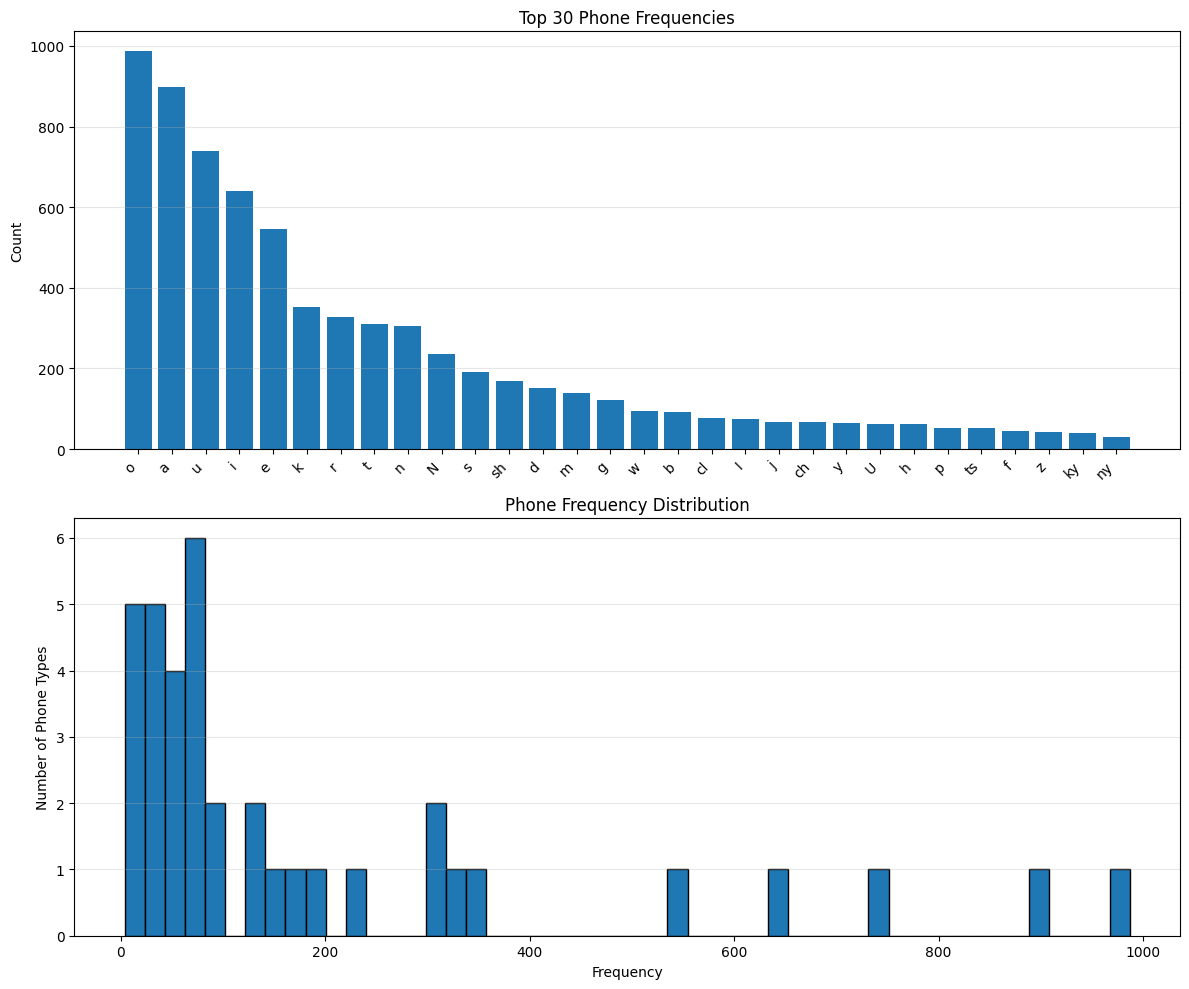


Rare phones (frequency <= 5): 1
Examples:
  v: 4


In [5]:
# 3. コーパス全体の音素カバレッジを見る

# 全音素をフラットにして集計
all_phones = []
for phones in phone_dict.values():
    all_phones.extend(phones)

phone_counter = Counter(all_phones)
total_phone_count = len(all_phones)
unique_phone_count = len(phone_counter)

print(f"Total phone tokens: {total_phone_count}")
print(f"Unique phone types: {unique_phone_count}")
print(f"\nTop 20 most frequent phones:")
for ph, count in phone_counter.most_common(20):
    print(f"  {ph:5s}: {count:4d} ({count/total_phone_count*100:.2f}%)")

# 音素頻度分布を可視化
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 上位30音素の頻度
top_phones = phone_counter.most_common(30)
phones_list, counts_list = zip(*top_phones) if top_phones else ([], [])

axes[0].bar(range(len(phones_list)), counts_list)
axes[0].set_xticks(range(len(phones_list)))
axes[0].set_xticklabels(phones_list, rotation=45, ha='right')
axes[0].set_title("Top 30 Phone Frequencies")
axes[0].set_ylabel("Count")
axes[0].grid(axis='y', alpha=0.3)

# 頻度分布のヒストグラム
frequencies = list(phone_counter.values())
axes[1].hist(frequencies, bins=50, edgecolor='black')
axes[1].set_title("Phone Frequency Distribution")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Number of Phone Types")
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# レア音素（出現回数が少ない音素）を確認
rare_threshold = 5  # 5回以下をレアとする
rare_phones = {ph: count for ph, count in phone_counter.items() if count <= rare_threshold}
print(f"\nRare phones (frequency <= {rare_threshold}): {len(rare_phones)}")
if rare_phones:
    print("Examples:")
    for ph, count in sorted(rare_phones.items(), key=lambda x: x[1])[:10]:
        print(f"  {ph}: {count}")


Greedy Phone Coverage Results
Total unique phones: 37
Selected sentences: 4
Covered phones: 37
Coverage: 100.00%

Selected sentence IDs:
   1. VOICEACTRESS100_054
   2. VOICEACTRESS100_011
   3. VOICEACTRESS100_022
   4. VOICEACTRESS100_015


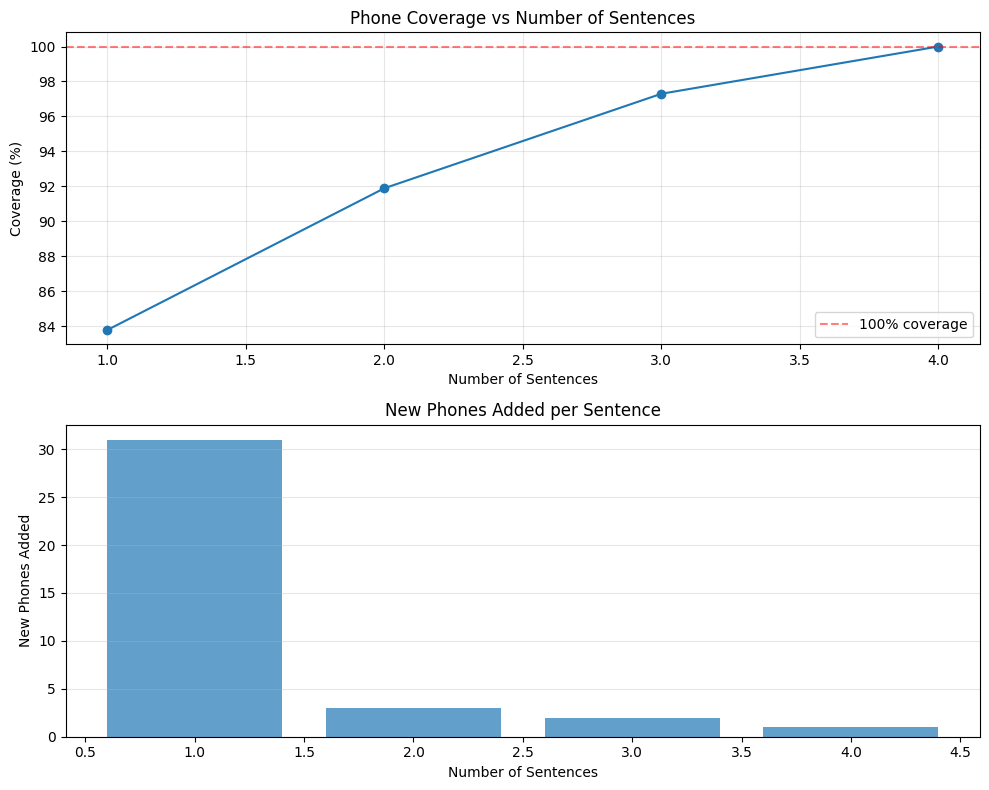

In [6]:
# 4. 「音素的に効率の良い文」を探す（貪欲法）

def greedy_phone_coverage(
    phone_dict: Dict[str, List[str]], 
    max_sentences: int = 20,
    target_coverage: float = 1.0
) -> Tuple[List[str], Dict[str, any]]:
    """
    貪欲法で音素カバレッジを最大化する文セットを選ぶ
    
    Returns:
        selected_ids: 選ばれた文IDのリスト
        stats: 統計情報
    """
    # 全音素集合
    all_unique_phones = set()
    for phones in phone_dict.values():
        all_unique_phones.update(phones)
    total_unique_phones = len(all_unique_phones)
    
    # 各文がカバーする音素集合を事前計算
    phone_sets = {file_id: set(phones) for file_id, phones in phone_dict.items()}
    
    selected_ids = []
    covered_phones = set()
    coverage_history = []
    
    remaining_ids = set(phone_dict.keys())
    
    while remaining_ids and len(selected_ids) < max_sentences:
        best_id = None
        best_new_phones = set()
        best_new_count = 0
        
        # 各候補文について、新規カバーできる音素数を計算
        for file_id in remaining_ids:
            new_phones = phone_sets[file_id] - covered_phones
            new_count = len(new_phones)
            
            if new_count > best_new_count:
                best_id = file_id
                best_new_phones = new_phones
                best_new_count = new_count
        
        if best_id is None or best_new_count == 0:
            # 新規カバーできる音素がない場合は終了
            break
        
        # 最良の文を選択
        selected_ids.append(best_id)
        covered_phones.update(best_new_phones)
        remaining_ids.remove(best_id)
        
        coverage = len(covered_phones) / total_unique_phones
        coverage_history.append({
            "num_sentences": len(selected_ids),
            "coverage": coverage,
            "new_phones": best_new_count,
            "total_covered": len(covered_phones)
        })
        
        if coverage >= target_coverage:
            break
    
    stats = {
        "selected_ids": selected_ids,
        "coverage_history": coverage_history,
        "final_coverage": len(covered_phones) / total_unique_phones,
        "total_unique_phones": total_unique_phones,
        "covered_phones": len(covered_phones),
        "num_sentences": len(selected_ids)
    }
    
    return selected_ids, stats

# 貪欲法を実行
selected_ids, stats = greedy_phone_coverage(phone_dict, max_sentences=20)

print("=" * 60)
print("Greedy Phone Coverage Results")
print("=" * 60)
print(f"Total unique phones: {stats['total_unique_phones']}")
print(f"Selected sentences: {stats['num_sentences']}")
print(f"Covered phones: {stats['covered_phones']}")
print(f"Coverage: {stats['final_coverage']*100:.2f}%")
print(f"\nSelected sentence IDs:")
for i, sid in enumerate(selected_ids, 1):
    print(f"  {i:2d}. {sid}")

# カバレッジの推移を可視化
if stats['coverage_history']:
    history_df = pd.DataFrame(stats['coverage_history'])
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    
    axes[0].plot(history_df['num_sentences'], history_df['coverage'] * 100, marker='o')
    axes[0].axhline(y=100, color='r', linestyle='--', alpha=0.5, label='100% coverage')
    axes[0].set_xlabel("Number of Sentences")
    axes[0].set_ylabel("Coverage (%)")
    axes[0].set_title("Phone Coverage vs Number of Sentences")
    axes[0].grid(alpha=0.3)
    axes[0].legend()
    
    axes[1].bar(history_df['num_sentences'], history_df['new_phones'], alpha=0.7)
    axes[1].set_xlabel("Number of Sentences")
    axes[1].set_ylabel("New Phones Added")
    axes[1].set_title("New Phones Added per Sentence")
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [7]:
# 5. 文ごとの"情報量"の簡易指標を作る

# レア音素の定義（出現頻度が下位20%の音素）
phone_freq_list = list(phone_counter.values())
rare_threshold = np.percentile(phone_freq_list, 20)

print(f"Rare phone threshold (20th percentile): {rare_threshold:.1f}")

# 各文について情報量指標を計算
info_metrics = []
for idx, row in df.iterrows():
    phones = row['phones']
    unique_phones = row['unique_phones']
    
    # レア音素の数
    rare_phone_count = sum(1 for ph in unique_phones if phone_counter[ph] <= rare_threshold)
    
    # 音素の多様性（ユニーク音素数 / 総音素数）
    diversity = row['num_unique_phones'] / row['num_phones'] if row['num_phones'] > 0 else 0
    
    # 平均出現頻度（低いほどレア音素が多い）
    avg_freq = np.mean([phone_counter[ph] for ph in phones])
    
    info_metrics.append({
        "id": row['id'],
        "rare_phone_count": rare_phone_count,
        "diversity": diversity,
        "avg_phone_freq": avg_freq,
        "info_score": rare_phone_count * diversity  # 簡易的な情報量スコア
    })

info_df = pd.DataFrame(info_metrics)
df = df.merge(info_df, on='id', how='left')

print("\nInformation Metrics Statistics:")
print(df[['num_phones', 'num_unique_phones', 'rare_phone_count', 'diversity', 'info_score']].describe())

# 情報量の高い文トップ10
print("\nTop 10 sentences by info_score:")
top_info = df.nlargest(10, 'info_score')[['id', 'num_phones', 'num_unique_phones', 'rare_phone_count', 'info_score']]
print(top_info.to_string(index=False))


Rare phone threshold (20th percentile): 31.2

Information Metrics Statistics:
       num_phones  num_unique_phones  rare_phone_count   diversity  info_score
count  100.000000         100.000000        100.000000  100.000000  100.000000
mean    71.560000          21.200000          1.190000    0.311705    0.366853
std     20.278525           2.957613          0.906709    0.063346    0.294918
min     33.000000          15.000000          0.000000    0.195804    0.000000
25%     59.000000          19.000000          1.000000    0.267886    0.233155
50%     70.500000          21.000000          1.000000    0.303954    0.312500
75%     84.000000          23.000000          2.000000    0.343670    0.527523
max    143.000000          31.000000          4.000000    0.484848    1.448276

Top 10 sentences by info_score:
                 id  num_phones  num_unique_phones  rare_phone_count  info_score
VOICEACTRESS100_017          58                 21                 4    1.448276
VOICEACTRESS100_

In [8]:
# 6. 各文がカバーする新規音素数を計算（貪欲法で選ばれた順序に基づく）

# 貪欲法で選ばれた順序で、各文が追加する新規音素数を計算
covered_so_far = set()
new_phone_counts = []

for file_id in selected_ids:
    phones_set = set(phone_dict[file_id])
    new_phones = phones_set - covered_so_far
    new_phone_counts.append(len(new_phones))
    covered_so_far.update(phones_set)

# DataFrameに追加
df['new_phones_if_selected'] = 0
for i, file_id in enumerate(selected_ids):
    if file_id in df['id'].values:
        df.loc[df['id'] == file_id, 'new_phones_if_selected'] = new_phone_counts[i]

# 最終的なDataFrameを表示
print("=" * 60)
print("Final DataFrame Summary")
print("=" * 60)
print(f"Total rows: {len(df)}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nSample rows (selected sentences):")
selected_df = df[df['id'].isin(selected_ids)].copy()
selected_df = selected_df.sort_values('new_phones_if_selected', ascending=False)
print(selected_df[['id', 'num_phones', 'num_unique_phones', 'rare_phone_count', 
                   'new_phones_if_selected', 'info_score']].to_string(index=False))


Final DataFrame Summary
Total rows: 100

Columns: ['id', 'text', 'phones', 'num_phones', 'unique_phones', 'num_unique_phones', 'rare_phone_count', 'diversity', 'avg_phone_freq', 'info_score', 'new_phones_if_selected']

Sample rows (selected sentences):
                 id  num_phones  num_unique_phones  rare_phone_count  new_phones_if_selected  info_score
VOICEACTRESS100_054         119                 31                 2                      31    0.521008
VOICEACTRESS100_011          75                 23                 3                       3    0.920000
VOICEACTRESS100_022         117                 28                 3                       2    0.717949
VOICEACTRESS100_015          45                 19                 2                       1    0.844444


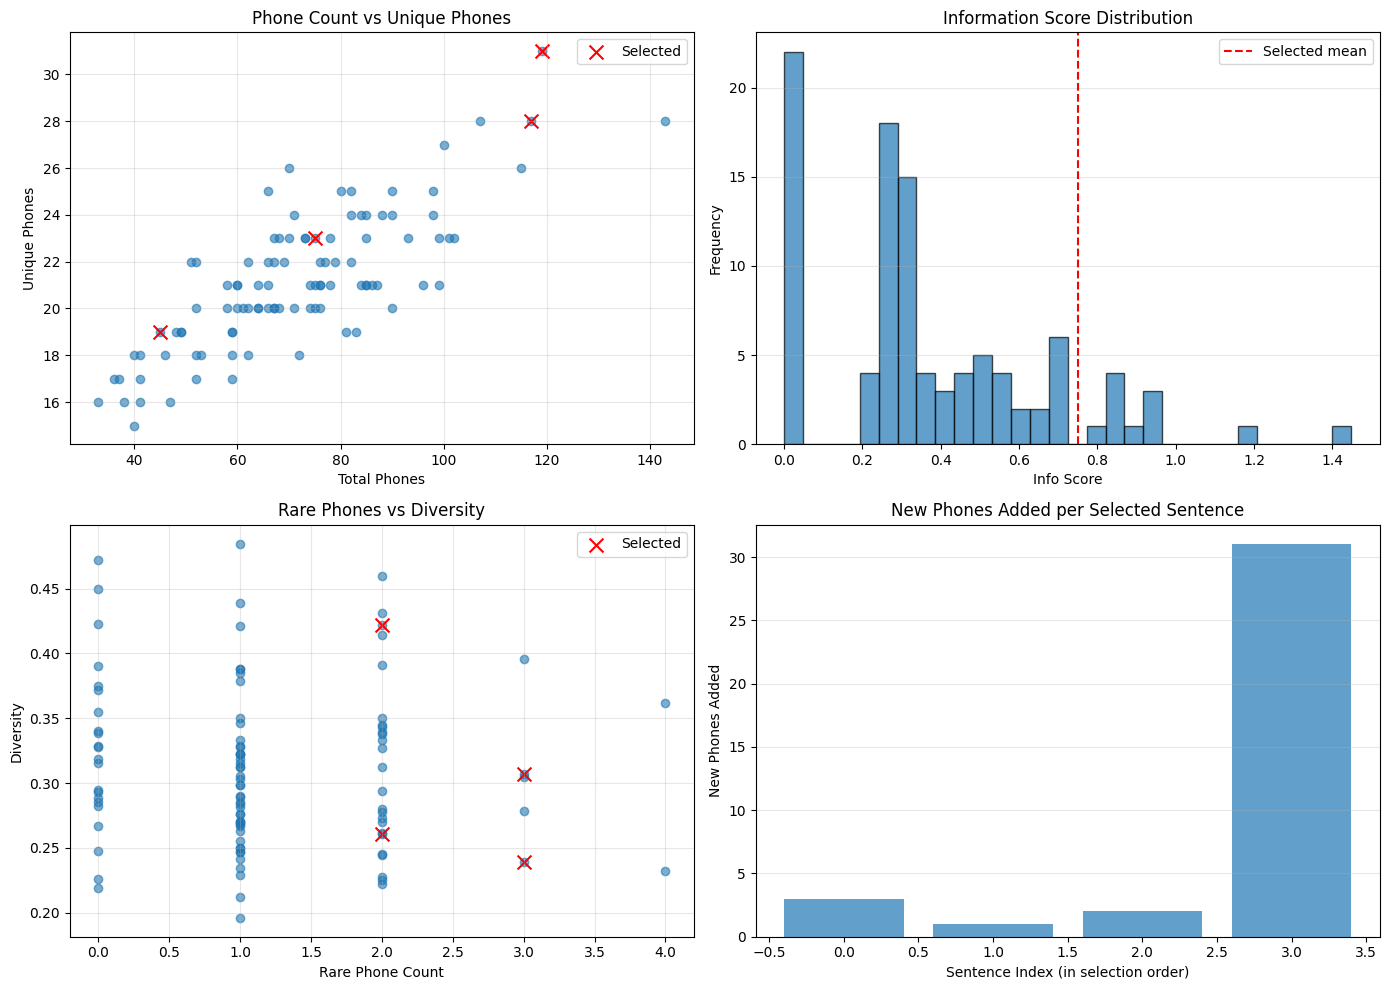

In [9]:
# 7. 可視化：文の特徴量分布

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 音素数 vs ユニーク音素数
axes[0, 0].scatter(df['num_phones'], df['num_unique_phones'], alpha=0.6)
axes[0, 0].set_xlabel('Total Phones')
axes[0, 0].set_ylabel('Unique Phones')
axes[0, 0].set_title('Phone Count vs Unique Phones')
axes[0, 0].grid(alpha=0.3)
# 選ばれた文をハイライト
selected_mask = df['id'].isin(selected_ids)
axes[0, 0].scatter(df[selected_mask]['num_phones'], 
                   df[selected_mask]['num_unique_phones'], 
                   color='red', marker='x', s=100, label='Selected')
axes[0, 0].legend()

# 情報量スコアの分布
axes[0, 1].hist(df['info_score'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df[selected_mask]['info_score'].mean(), 
                   color='red', linestyle='--', label='Selected mean')
axes[0, 1].set_xlabel('Info Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Information Score Distribution')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# レア音素数 vs 多様性
axes[1, 0].scatter(df['rare_phone_count'], df['diversity'], alpha=0.6)
axes[1, 0].set_xlabel('Rare Phone Count')
axes[1, 0].set_ylabel('Diversity')
axes[1, 0].set_title('Rare Phones vs Diversity')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].scatter(df[selected_mask]['rare_phone_count'], 
                   df[selected_mask]['diversity'], 
                   color='red', marker='x', s=100, label='Selected')
axes[1, 0].legend()

# 新規カバー音素数（選ばれた文のみ）
if selected_mask.sum() > 0:
    selected_new_phones = df[selected_mask]['new_phones_if_selected']
    axes[1, 1].bar(range(len(selected_new_phones)), selected_new_phones.values, alpha=0.7)
    axes[1, 1].set_xlabel('Sentence Index (in selection order)')
    axes[1, 1].set_ylabel('New Phones Added')
    axes[1, 1].set_title('New Phones Added per Selected Sentence')
    axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
# 8. 結果の保存

output_dir = PROJECT_ROOT / "outputs" / "corpus_analysis" / SPEAKER_ID
output_dir.mkdir(parents=True, exist_ok=True)

# DataFrameをCSVで保存（音素列は文字列として保存）
df_export = df.copy()
df_export['phones'] = df_export['phones'].apply(lambda x: ' '.join(x))
df_export['unique_phones'] = df_export['unique_phones'].apply(lambda x: ' '.join(sorted(x)))
df_export.to_csv(output_dir / "corpus_analysis.csv", index=False, encoding='utf-8')

# 音素頻度を保存
phone_freq_df = pd.DataFrame([
    {"phone": ph, "count": count, "frequency": count/total_phone_count}
    for ph, count in phone_counter.most_common()
])
phone_freq_df.to_csv(output_dir / "phone_frequencies.csv", index=False, encoding='utf-8')

# 選ばれた文セットを保存
selected_df_export = df[df['id'].isin(selected_ids)].copy()
selected_df_export['phones'] = selected_df_export['phones'].apply(lambda x: ' '.join(x))
selected_df_export['unique_phones'] = selected_df_export['unique_phones'].apply(lambda x: ' '.join(sorted(x)))
selected_df_export.to_csv(output_dir / "selected_sentences.csv", index=False, encoding='utf-8')

# 統計サマリーを保存
summary = {
    "total_sentences": len(df),
    "total_phone_tokens": total_phone_count,
    "unique_phone_types": unique_phone_count,
    "selected_sentences": len(selected_ids),
    "coverage_achieved": stats['final_coverage'],
    "selected_ids": selected_ids
}

import json
with open(output_dir / "summary.json", 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print(f"Results saved to: {output_dir}")
print(f"  - corpus_analysis.csv: Full analysis data")
print(f"  - phone_frequencies.csv: Phone frequency statistics")
print(f"  - selected_sentences.csv: Greedy-selected sentence set")
print(f"  - summary.json: Summary statistics")


Results saved to: /mnt/c/dev/minimal-feature-corpus-tts/outputs/corpus_analysis/jvs002
  - corpus_analysis.csv: Full analysis data
  - phone_frequencies.csv: Phone frequency statistics
  - selected_sentences.csv: Greedy-selected sentence set
  - summary.json: Summary statistics


# このノートでやっていることと出力の読み方

## 全体像
- **対象データ**: `jvs002` 話者の `parallel100`（100文）
- **目的**: 「この100文がどんな音素をどれだけカバーしているか」を可視化し、音素的に効率の良い文セット候補を作ること

---

## Cell 1–2: ファイル対応付け
- **Cell 1 出力**
  - `Num lab files: 100` → `lab/mon` に 100 個のモノラベルファイルがあり、parallel100 の100文すべてに対応していることを確認。
  - `Transcript file exists: True` → 転写テキスト `transcripts_utf8.txt` が存在することを確認。
- **Cell 2 出力**
  - `Loaded 100 lab files` / `Loaded 100 transcripts` → ラベルとテキストがどちらも100文分そろっている。
  - `Example:` 以下で、あるIDについて「テキスト」と「最初の10音素」「総音素数」をサンプル表示して、対応関係が正しく取れていることを確認。

---

## Cell 3: 文ごとの音素統計（DataFrame）
- **主な列**
  - `id` : 文ID（例: `VOICEACTRESS100_001`）
  - `num_phones` : その文に含まれる音素トークン数（長さ）
  - `num_unique_phones` : その文に含まれるユニーク音素の種類数
- **出力の意味**
  - `DataFrame shape: (100, 6)` → 100文 × 6列のテーブルができている。
  - `Statistics` で、音素列の長さ分布とユニーク音素数の分布がわかる。
    - 例: `mean num_phones ≈ 71.6` → 1文あたり平均 ~72 音素。
    - `mean num_unique_phones ≈ 21.2` → 1文あたり平均 ~21 種類の音素を含む。

---

## Cell 4: コーパス全体の音素頻度とカバレッジ
- **テキスト出力**
  - `Total phone tokens: 7156` → 100文全体で 7,156 音素トークン。
  - `Unique phone types: 37` → 異なる音素の種類は 37 種類。
  - `Top 20 most frequent phones:` → 母音 / 子音ごとの頻度と全体に占める割合。
    - 例: `o: 987 (13.79%)` → /o/ が全トークンの約14% を占める。
  - `Rare phones (frequency <= 5): 1` → 5回以下しか出現しないレア音素は 1 種類（ここでは `v`）。
- **図（2枚）**
  - 上段: 上位30音素の出現回数バーグラフ → どの音素がどれくらい多いか。
  - 下段: 音素頻度のヒストグラム → 「よく出る音素」と「たまにしか出ない音素」のばらつき。

---

## Cell 5: 音素カバレッジ貪欲法（最小文セットの探索）
- **アルゴリズム**
  - まだカバーされていない音素をできるだけ多く含む文を1つずつ足していく（貪欲法）。
- **出力の読み方**
  - `Total unique phones: 37` → 目標とする音素種類数。
  - `Selected sentences: 4` → 4文選ぶだけで全37種類の音素をカバーできた。
  - `Coverage: 100.00%` → 音素カバレッジ100% 達成。
  - `Selected sentence IDs:` 以下の4つが「音素的に効率の良い文」候補。
  - 図（2枚）:
    - 上段: 文数を増やしたときのカバレッジ(%) の推移。
    - 下段: それぞれの文が新しく追加した音素種類数。

---

## Cell 6–7: 文ごとの“情報量”と新規音素数
- **Cell 6**: 情報量の指標
  - `rare_phone_count` : その文に含まれる「レア音素」（頻度が下位20%）の種類数。
  - `diversity` : `num_unique_phones / num_phones` → 長さに対する多様性。
  - `avg_phone_freq` : その文に出てくる音素の平均頻度（小さいほどレア寄り）。
  - `info_score` : `rare_phone_count * diversity` という簡易スコア。
  - `Top 10 sentences by info_score` → レア音素が多く、多様性も高い「情報量の高い文」ランキング。
- **Cell 7**: 新規音素数と最終DataFrame
  - `new_phones_if_selected` : 貪欲法の順序でその文を選んだときに増える新規音素種類数。
  - `Sample rows (selected sentences)` → 貪欲法で選ばれた4文について、
    - `num_phones`（長さ）
    - `num_unique_phones`（種類数）
    - `rare_phone_count`（レア音素の種類数）
    - `new_phones_if_selected`（新規カバー音素数）
    - `info_score`（情報量スコア）
    を一覧で確認できる。

---

## Cell 8: 可視化（文ごとの特徴量分布）
- 4つのプロットで、文ごとの特徴を俯瞰:
  1. **Total Phones vs Unique Phones**
     - 縦軸: ユニーク音素数、横軸: 音素トークン数 → 長くて多様な文 / 短いが多様な文 などが見て取れる。
     - 赤いバツ印: 貪欲法で選ばれた文。
  2. **Information Score Distribution**
     - 情報量スコアの分布と、選ばれた文の平均スコア（赤破線）。
  3. **Rare Phones vs Diversity**
     - レア音素数と多様性の関係。右上にある点ほど「レアで多様」な文。
  4. **New Phones Added per Selected Sentence**
     - 選ばれた各文が何種類の新規音素を追加したか。

---

## Cell 9: 結果の保存
- `outputs/corpus_analysis/jvs002/` 以下に解析結果を保存:
  - `corpus_analysis.csv` : 各文ごとの詳細な統計（このノートのDataFrame相当）。
  - `phone_frequencies.csv` : 音素ごとの頻度と相対頻度。
  - `selected_sentences.csv` : 貪欲法で選ばれた文セットのサマリ。
  - `summary.json` : 文数・音素数・カバレッジなどの要約値。

---

## ここまででわかること
- jvs002 parallel100 では **37種類** の音素が使われている。
- そのすべてをカバーするには、**4文** 選べば十分（音素的な意味での最小文セット候補）。
- 各文について、「長さ」「多様性」「レア音素の多さ」などを指標化してあり、
  - 「音素的に効率の良い文」
  - 「レア音素を多く含む文」
  - 「情報量スコアの高い文」
  を後続ステップ（F0 / メル特徴量と組み合わせた設計）で選びやすい状態になっている。
